# Homework 2 - Convolutional Neural Nets

In this homework, we will be working with google [colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on google servers using a GPU or TPU. To enable GPU support, make sure to press Runtime -> Change Runtime Type -> GPU. 

## Cats vs dogs classification

To learn about and experiment with convolutional neural nets we will be working on a problem of great importance in computer vision - classifying images of cats and dogs.

The problem is so important that there's even an easter egg in colab: go to Tools -> Settings -> Miscellaneous and enable 'Corgi mode' and 'Kitty mode' to get more cats and dogs to classify when you're tired of coding.



### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [1]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2022-03-03 01:08:05--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 74.125.129.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   190MB/s    in 0.3s    

2022-03-03 01:08:05 (190 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip cats_and_dogs_filtered.zip 

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.

This dataset contains two directories, `train` and `validation`. Both in turn contain two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats, and another 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a convolutional neural net to classify these images, i.e. given an image from this dataset, tell if it contains a cat or a dog.



In [3]:
! echo 'Training cats examples:' $(find cats_and_dogs_filtered/train/cats -type f | wc -l)
! echo 'Training dogs examples:' $(find cats_and_dogs_filtered/train/dogs -type f | wc -l)
! echo 'Validation cats examples:' $(find cats_and_dogs_filtered/validation/cats -type f | wc -l)
! echo 'Validation dogs examples:' $(find cats_and_dogs_filtered/validation/dogs -type f | wc -l)

Training cats examples: 1000
Training dogs examples: 1000
Validation cats examples: 500
Validation dogs examples: 500


### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch ecosystem, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html). 

 In the case of computer vision, the datasets with the folder structure 'label_name/image_file' are very common, and to process those there's already a class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). Torchvision is a Pytorch library with many commonly used tools in computer vision.

 Another thing we need from Torchvision library is transforms ([documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)). In computer vision, we very often want to transform the images in certain ways. The most common is normalization. Others include flipping, changing saturation, hue, contrast, rotation, and blurring. 

 Below, we create a training, validation and test sets. We use a few transforms for augmentation on the training set, but we don't use anything but resize and normalization for validation and test. 

In [4]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images

# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, resample=Image.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(),  # convert PIL to Pytorch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(), 
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
validation_dataset, test_dataset = torch.utils.data.random_split(torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms), [500, 500], generator=torch.Generator().manual_seed(42))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

1


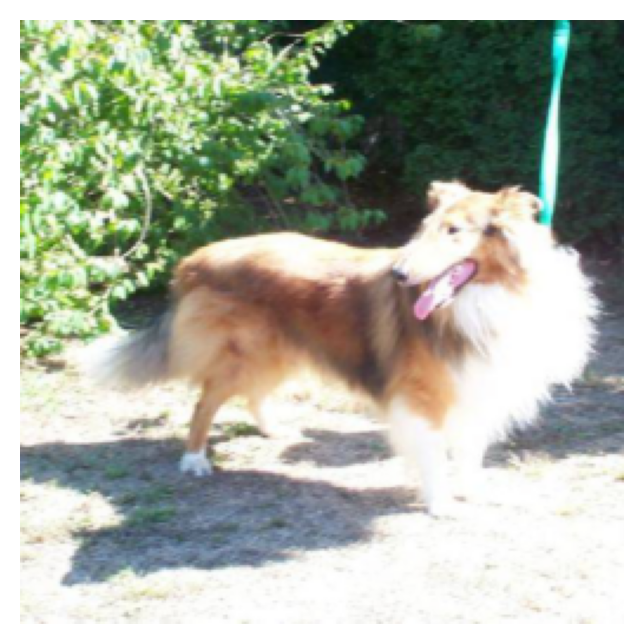

In [5]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
  plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

show_normalized_image(test_dataset[7][0])
print(test_dataset[7][1])

In [6]:
train_dataset[10][0].shape

torch.Size([3, 256, 256])

### Creating the model

Now is the time to create a model. All models in Pytorch are subclassing `torch.nn.Module`, and have to implement `__init__` and `forward` methods. 

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a convolutional neural network containing the following elements:

* Convolutional layers (at least two)
* Batch Norm
* Non-linearity
* Pooling layers
* A residual connection similar to that of Res-Net
* A fully connected layer

For some examples of how to implement Pytorch models, please refer to our lab notebooks, such as [this one](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb).

In [7]:
from torch import nn
import torch.nn.functional as F

class CNN(torch.nn.Module):

  def __init__(self):
    super().__init__()
    # Image shape (3,256,256)

    self.down1 = torch.nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, stride=2, kernel_size=7), # 64*125*125
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2))  # 64*62*62                
    self.conv1_1_x = torch.nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())  # 64*62*62 
    self.conv1_2_x = torch.nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())  # 64*62*62
    self.down2 = torch.nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, stride=2, kernel_size=3), #128*30*30
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU())  #128*30*30
    self.conv2_1_x = torch.nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU())  #128*30*30 
    self.conv2_2_x = torch.nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU())  #128*30*30 
    self.down3 = torch.nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, stride=2, kernel_size=3,padding=1), #256*15*15
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU())  #256*15*15
    self.conv3_1_x = torch.nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=256, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU())  #256*15*15
    self.conv3_2_x = torch.nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=256, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU())  #256*15*15
    self.down4 = torch.nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, stride=2, kernel_size=3,padding=1), #512*8*8
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU())  #512*8*8    
    self.conv4_1_x = torch.nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU())  #512*8*8
    self.conv4_2_x = torch.nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, stride=1, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU())  #512*8*8
    self.pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512, 2)

    
  def forward(self, x):
    x = self.down1(x)
    x = self.conv1_1_x(x)+x
    x = self.conv1_2_x(x)+x
    x = self.down2(x)
    x = self.conv2_1_x(x)+x
    x = self.conv2_2_x(x)+x
    x = self.down3(x)
    x = self.conv3_1_x(x)+x
    x = self.conv3_2_x(x)+x
    x = self.down4(x)
    x = self.conv4_1_x(x)+x
    x = self.conv4_2_x(x)+x
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    out = F.log_softmax(x, dim=1)
    return out


### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [8]:
from tqdm.notebook import tqdm

def get_loss_and_correct(model, batch, criterion, device):
  # Implement forward pass and loss calculation for one batch.
  # Remember to move the batch to device.
  # 
  # Return a tuple:
  # - loss for the batch (Tensor)
  # - number of correctly classified examples in the batch (Tensor)
  (data, target) = batch
  data, target = data.to(device), target.to(device)
  data = data.view(-1, 3, 256, 256)
  output = model(data)
  loss = criterion(output, target)
  pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability    
  correct = pred.eq(target.data.view_as(pred)).cpu().sum()
  #print(loss,pred.shape,pred,target.shape,target,correct.shape,correct)
  return loss,correct

def step(loss, optimizer):
  # Implement backward pass and update.
  # TODO
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


N_EPOCHS = 30
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)
model = CNN()

criterion = nn.NLLLoss() # TODO

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # TODO

model.train()

if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
  total_train_loss = 0.0
  total_train_correct = 0.0
  total_validation_loss = 0.0
  total_validation_correct = 0.0

  model.train()

  for batch in tqdm(train_dataloader, leave=False):
    loss, correct = get_loss_and_correct(model, batch, criterion, device)
    step(loss, optimizer)
    total_train_loss += loss.item()
    total_train_correct += correct.item()

  with torch.no_grad():
    for batch in validation_dataloader:
      loss, correct = get_loss_and_correct(model, batch, criterion, device)
      total_validation_loss += loss.item()
      total_validation_correct += correct.item()

  mean_train_loss = total_train_loss / len(train_dataset)
  train_accuracy = total_train_correct / len(train_dataset)

  mean_validation_loss = total_validation_loss / len(validation_dataset)
  validation_accuracy = total_validation_correct / len(validation_dataset)

  train_losses.append(mean_train_loss)
  validation_losses.append(mean_validation_loss)

  train_accuracies.append(train_accuracy)
  validation_accuracies.append(validation_accuracy)
  print(train_accuracy,validation_accuracy)
  pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

0.536 0.494


  0%|          | 0/32 [00:00<?, ?it/s]

0.573 0.596


  0%|          | 0/32 [00:00<?, ?it/s]

0.6345 0.69


  0%|          | 0/32 [00:00<?, ?it/s]

0.654 0.588


  0%|          | 0/32 [00:00<?, ?it/s]

0.6635 0.672


  0%|          | 0/32 [00:00<?, ?it/s]

0.6725 0.68


  0%|          | 0/32 [00:00<?, ?it/s]

0.7025 0.686


  0%|          | 0/32 [00:00<?, ?it/s]

0.7045 0.716


  0%|          | 0/32 [00:00<?, ?it/s]

0.7075 0.722


  0%|          | 0/32 [00:00<?, ?it/s]

0.734 0.714


  0%|          | 0/32 [00:00<?, ?it/s]

0.742 0.74


  0%|          | 0/32 [00:00<?, ?it/s]

0.771 0.696


  0%|          | 0/32 [00:00<?, ?it/s]

0.77 0.71


  0%|          | 0/32 [00:00<?, ?it/s]

0.758 0.65


  0%|          | 0/32 [00:00<?, ?it/s]

0.771 0.75


  0%|          | 0/32 [00:00<?, ?it/s]

0.783 0.78


  0%|          | 0/32 [00:00<?, ?it/s]

0.8065 0.658


  0%|          | 0/32 [00:00<?, ?it/s]

0.803 0.782


  0%|          | 0/32 [00:00<?, ?it/s]

0.815 0.754


  0%|          | 0/32 [00:00<?, ?it/s]

0.833 0.734


  0%|          | 0/32 [00:00<?, ?it/s]

0.832 0.802


  0%|          | 0/32 [00:00<?, ?it/s]

0.8245 0.816


  0%|          | 0/32 [00:00<?, ?it/s]

0.8545 0.768


  0%|          | 0/32 [00:00<?, ?it/s]

0.8505 0.832


  0%|          | 0/32 [00:00<?, ?it/s]

0.8545 0.744


  0%|          | 0/32 [00:00<?, ?it/s]

0.8565 0.822


  0%|          | 0/32 [00:00<?, ?it/s]

0.86 0.726


  0%|          | 0/32 [00:00<?, ?it/s]

0.8555 0.848


  0%|          | 0/32 [00:00<?, ?it/s]

0.8725 0.784


  0%|          | 0/32 [00:00<?, ?it/s]

0.8725 0.82


Now that the model is trained, we want to visualize the training and validation losses and accuracies:

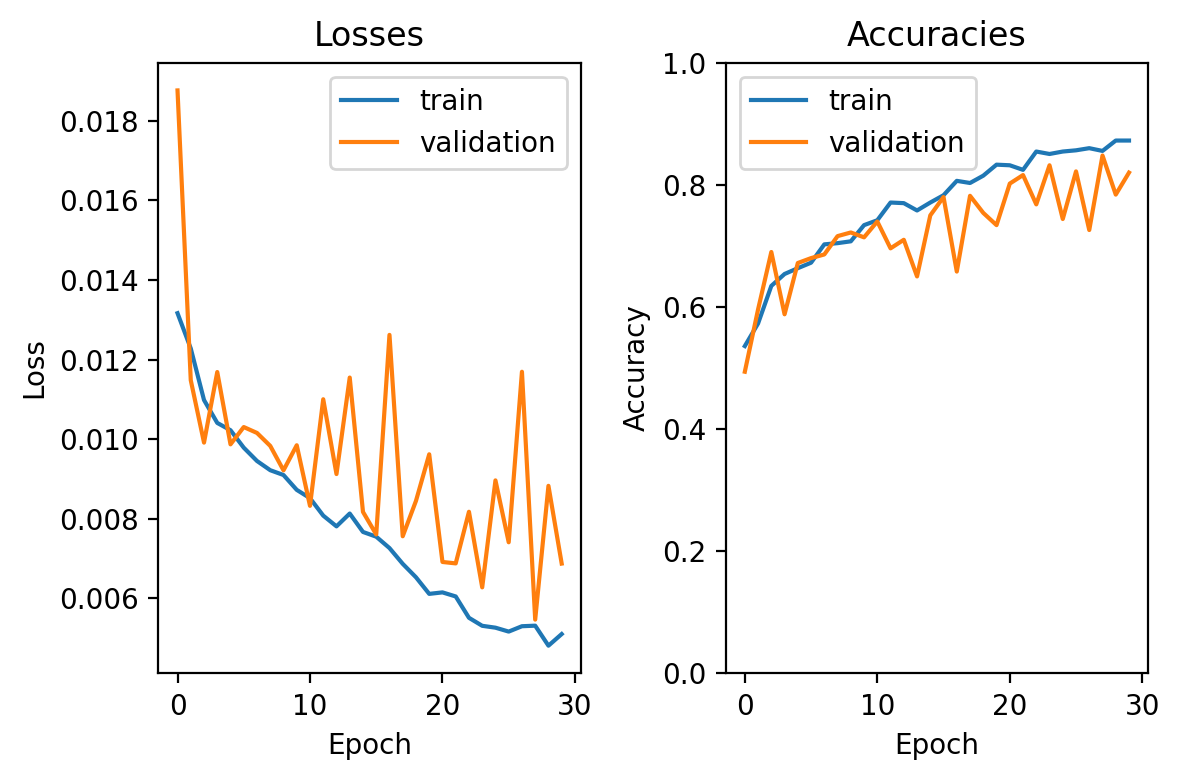

In [9]:
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()

Now, change your model to achieve at least 75% accuracy on validation set. You can change the model you've implemented, the optimizer, and the augmentations. 

Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

Answer: My model seems to overfit the training set. The validation loss is always higher than training loss after about 10 epochs. And the validation accuracy is alwas below training accuracy after about 10 epochs.

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Accuracy: 393/500 (79%)

Correct prefiction: 0 Prediction is:  tensor(1, device='cuda:0') True label is:  tensor(1, device='cuda:0')
Correct prefiction: 1 Prediction is:  tensor(0, device='cuda:0') True label is:  tensor(0, device='cuda:0')
Correct prefiction: 2 Prediction is:  tensor(0, device='cuda:0') True label is:  tensor(0, device='cuda:0')
Correct prefiction: 5 Prediction is:  tensor(0, device='cuda:0') True label is:  tensor(0, device='cuda:0')
Incorrect prefiction: 3 Prediction is:  tensor(0, device='cuda:0') True label is:  tensor(1, device='cuda:0')
Incorrect prefiction: 4 Prediction is:  tensor(0, device='cuda:0') True label is:  tensor(1, device='cuda:0')
Incorrect prefiction: 7 Prediction is:  tensor(0, device='cuda:0') True label is:  tensor(1, device='cuda:0')
Incorrect prefiction: 10 Prediction is:  tensor(0, device='cuda:0') True label is:  tensor(1, device='cuda:0')


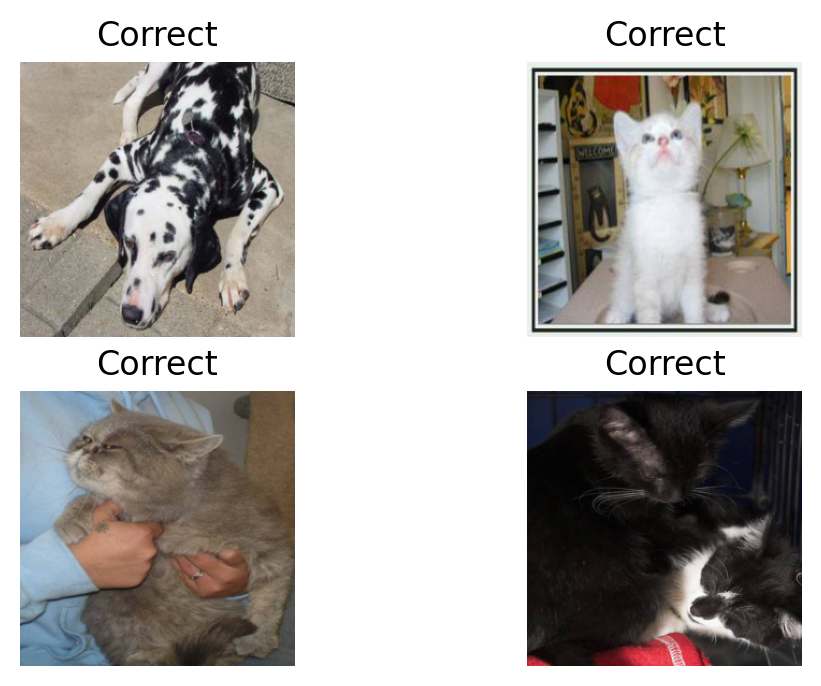

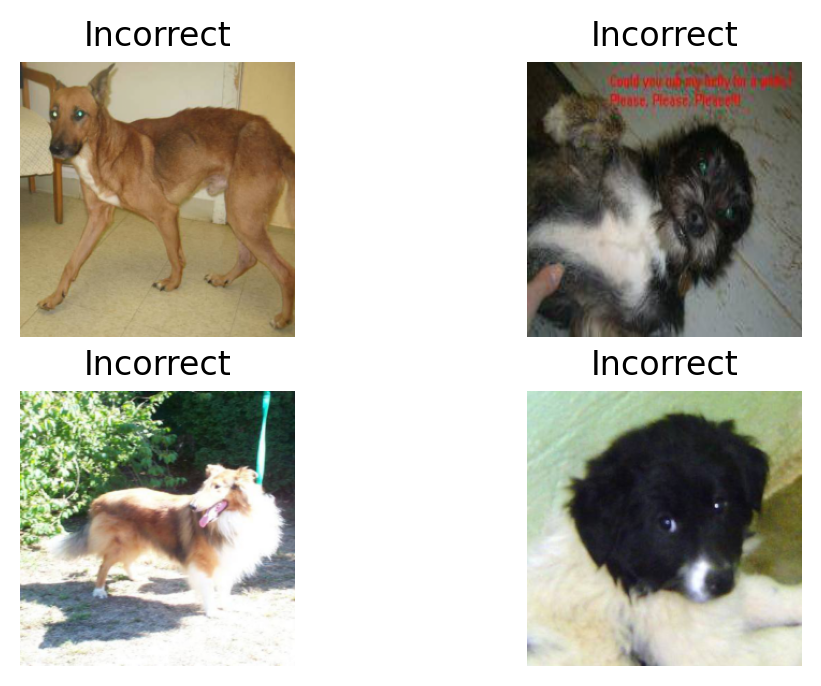

In [10]:
# TODO
# 1. Calculate and show the test_dataset accuracy of your model.
# 2. Visualize some correctly and incorrectly classified examples.
with torch.no_grad():
  test_loss = 0
  correct = 0
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, num_workers=4)
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data = data.view(-1, 3, 256, 256)
    model.to(device)
    output = model(data)                                                          
    pred = output.data.max(1, keepdim=True)[1].data.view_as(target)   # get the index of the max log-probability                                                             
    correct += pred.eq(target.data).cpu().sum().item()



  test_loss /= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)
  print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset),
          accuracy))
  cor = (pred==target).int().nonzero().view(correct).tolist()[0:4]
  incor = (pred!=target).int().nonzero().view(500-correct).tolist()[0:4]


  plt.figure()
  for i in range(len(cor)):
    c_data, _ = test_loader.dataset.__getitem__(cor[i])
    c_data = unnormalize(c_data)
    plt.subplot(2,2,i+1)
    img = c_data.view(3,256,256).cpu().swapaxes(0,1)
    img = img.swapaxes(1,2)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Correct')
    print('Correct prefiction:',cor[i],'Prediction is: ',pred[cor[i]],'True label is: ',target[cor[i]])

  plt.figure()
  for i in range(len(incor)):
    inc_data, _ = test_loader.dataset.__getitem__(incor[i])
    inc_data = unnormalize(inc_data)
    plt.subplot(2,2,i+1)
    img = inc_data.view(3,256,256).cpu().swapaxes(0,1)
    img = img.swapaxes(1,2)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Incorrect')
    print('Incorrect prefiction:',incor[i],'Prediction is: ',pred[incor[i]],'True label is: ',target[incor[i]])
    

### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

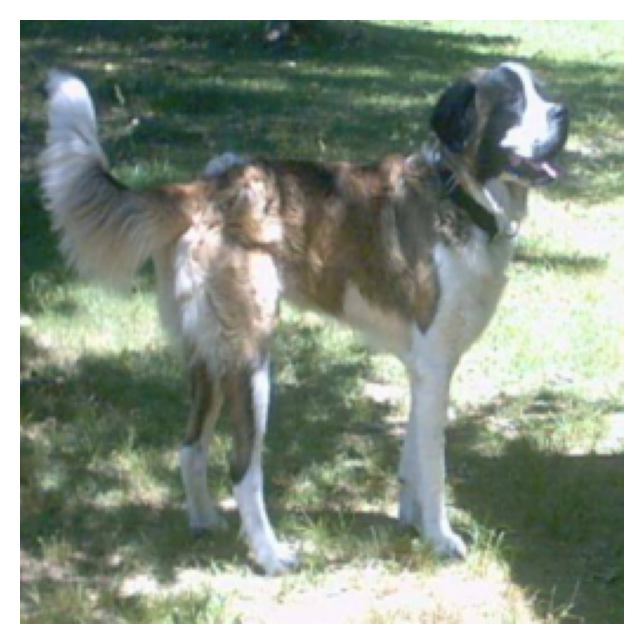

In [33]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to 'clip' our model at different points to get different intermediate representation. 
Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:4])
)
intermediate_output = clipped(input)
```



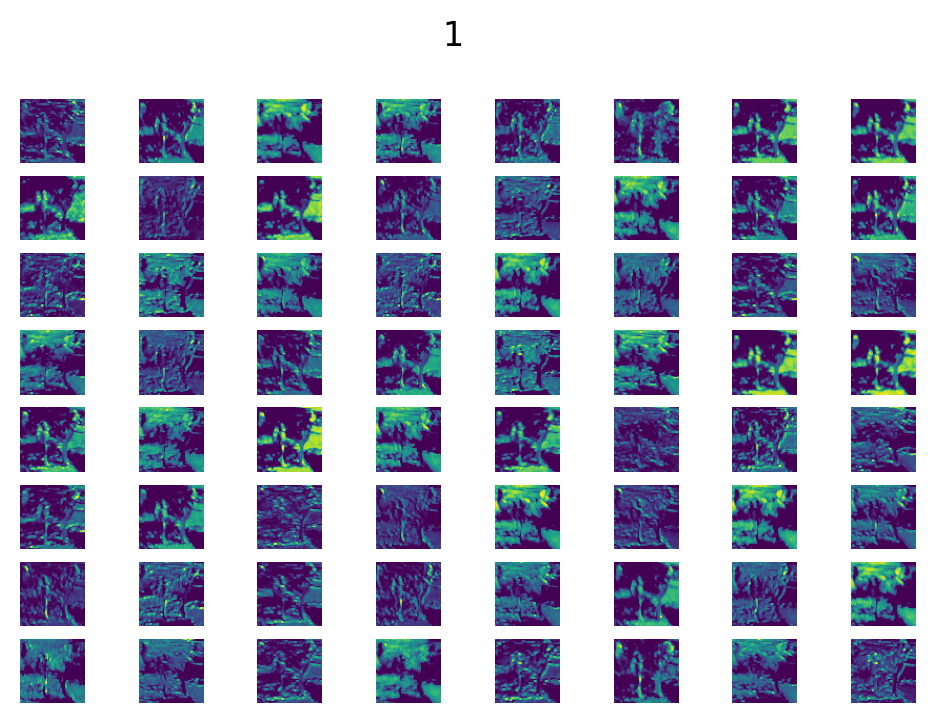

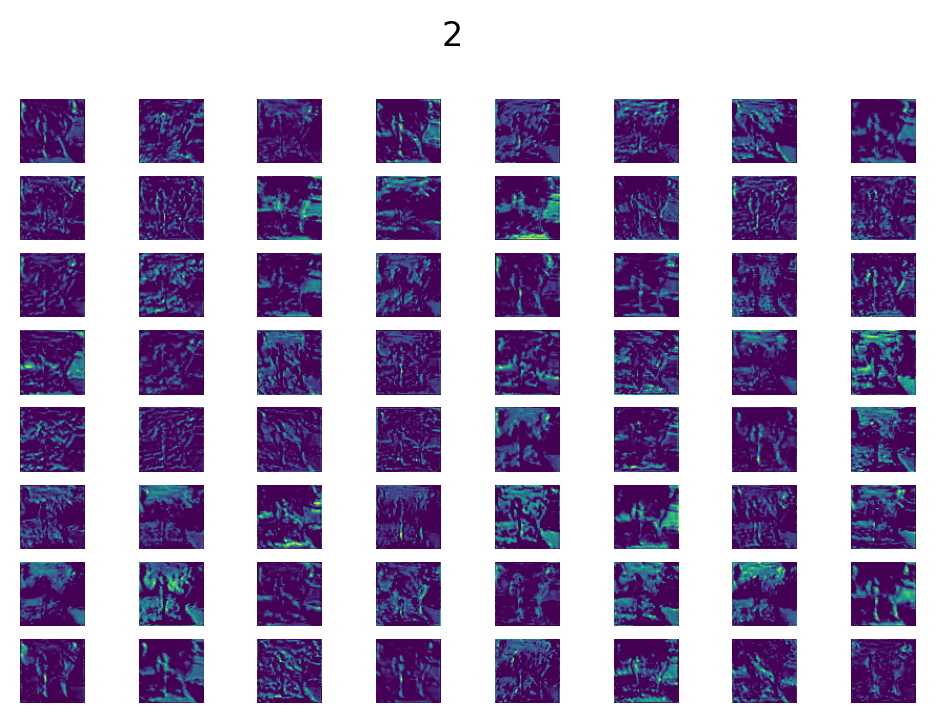

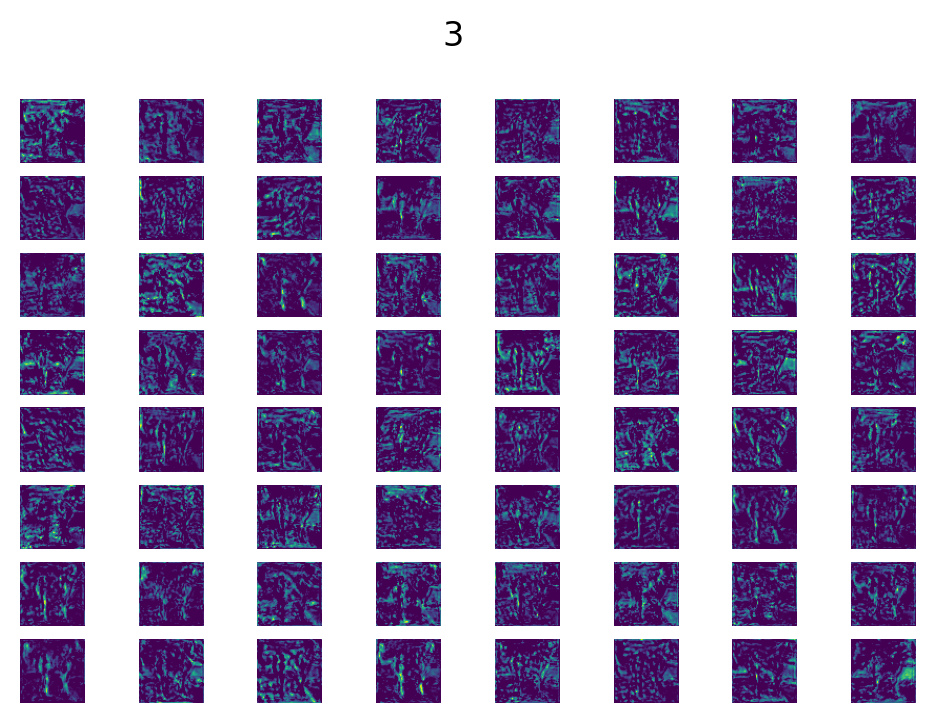

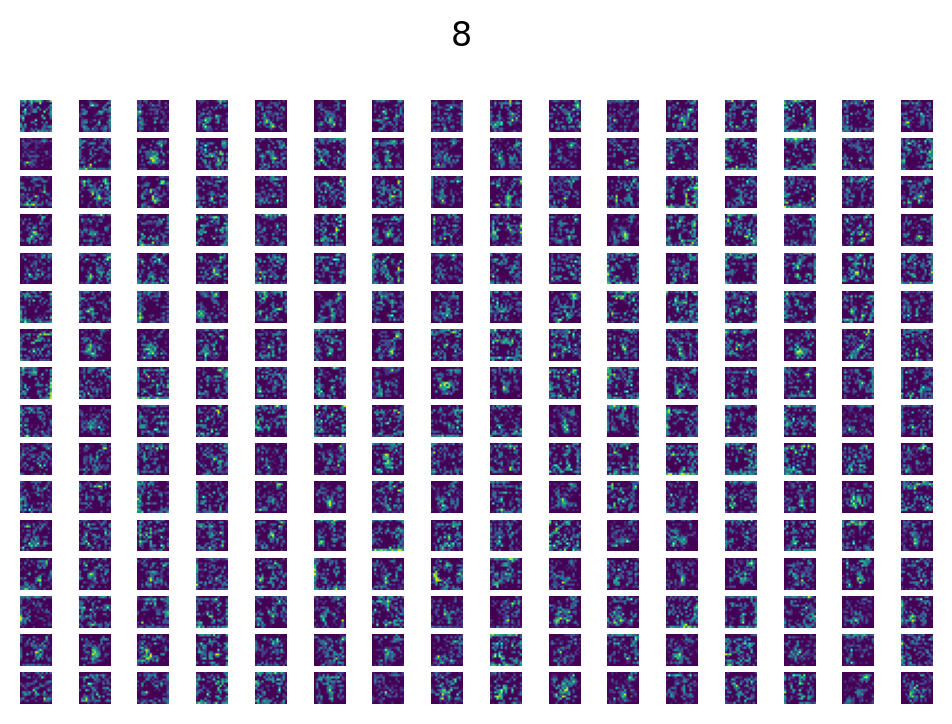

In [34]:
import math

def plot_intermediate_output(result, title):
  """ Plots the intermediate output of shape
      N_FILTERS x H x W
  """
  n_filters = result.shape[1]
  N = int(math.sqrt(n_filters))
  M = (n_filters + N - 1) // N
  assert N * M >= n_filters
  
  fig, axs = plt.subplots(N, M)
  fig.suptitle(title)
  
  for i in range(N):
    for j in range(M):
      if i*N + j < n_filters:
        axs[i][j].imshow(result[0, i*N + j].cpu().detach())
        axs[i][j].axis('off')

# TODO: 
# pick a few intermediate representations from your network and plot them using 
# the provided function.
single_data = image.to(device)

clipped1 = nn.Sequential(
    *list(model.children())[:1])
intermediate_output1 = clipped1(single_data.view(-1,3,256,256))
plot_intermediate_output(intermediate_output1, '1')

clipped2 = nn.Sequential(
    *list(model.children())[:2])
intermediate_output2 = clipped2(single_data.view(-1,3,256,256))
plot_intermediate_output(intermediate_output2, '2')

clipped3 = nn.Sequential(
    *list(model.children())[:3])
intermediate_output3 = clipped3(single_data.view(-1,3,256,256))
plot_intermediate_output(intermediate_output3, '3')

clipped8 = nn.Sequential(
    *list(model.children())[:8])
intermediate_output8 = clipped8(single_data.view(-1,3,256,256))
plot_intermediate_output(intermediate_output8, '8')

What can you say about those filters? What features are they focusing on?

Anwer: The sizes of filters are decreasing as the layer goes deeper, and the numbers of the filters are increasing as the layer goew deeper. The first layer focuses on colors, where region of similar color is activated similarly. The layer 2 and layer 3 seem to focus more on the edges in the images. The features output by deeper layears like layer 8 are more abstract.